In [2]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import yaml

check_sum_length = 5

# n_samples / sample_rate = duration in seconds
def create_sin_wave(freq, n_samples=44100, sample_rate=44100, amplitude=10000,
        save_to_file=None, graph=True):
    x = np.arange(n_samples)
    y = amplitude * np.sin(2 * np.pi * freq * x / sample_rate)
    if graph:
        plt.plot(y)
        plt.xlim(0, 512)
    if save_to_file is not None:
        output_array = y.astype(np.int16)
        wavfile.write(save_to_file, sample_rate, output_array)
    else:
        return y.astype(np.int16)

def get_signal(data_seq, sample_size=1024, write_to_file=None):
    tot_signal = list()
    for i in data_seq:
        if i == 0:
            signal = create_sin_wave(18 * 1000, n_samples=1024, graph=False)
        else:
            signal = create_sin_wave(19 * 1000, n_samples=1024, graph=False)
        tot_signal.extend(signal)
    print('generated signal of length {}'.format(len(tot_signal)))
    if write_to_file is not None:
        wavfile.write(write_to_file, 44100, np.array(tot_signal))
    return np.array(tot_signal).astype(np.int16)

# if output_length > music: the resulting signal conforms to music_length
# if output_length > data_signal: data_signal will be repeated to fit output_length
# all units here are in terms of number of samples points
def mix_with_music(data_signal, music_name, output_length=2*44100,    # use output_length of -1 for no trimming
                   # Note that 1024 * 5 means we will wait for 5 FFT intervals before
                   # attempting to transmit the next data sequence
                   start_delay=1024 * 5,
                   to_mono=True, graph=False,write_to_file=None):
    # 1. Extract Music Signals
    fs, data =  wavfile.read(music_name)
    if output_length == -1:
        output_length = len(data)
    music_signal = data[:output_length]
    if to_mono:
        music_signal = np.mean(music_signal, axis=1).astype(np.int16)

    # 2. Repeat + Pad Data Signals
    # if we can't fit data into music for kth time, it's ok to leave it as k - 1
    repeat_num = int(np.floor(output_length / (start_delay + len(data_signal))))
    # use music signal as base
    expanded_data_signal = []
    print('output repeates data signal {} times ({:.3f})'.format(repeat_num, output_length / (start_delay + len(data_signal))))
    for _ in range(repeat_num):
        expanded_data_signal.extend(list(np.zeros(start_delay, dtype=np.int16)))
        expanded_data_signal.extend(data_signal)
    # add zero paddings to match size of data and music
    while len(expanded_data_signal) < output_length:
        expanded_data_signal.append(0)

    # 3. Data + Music
    new_signal = np.array(expanded_data_signal, dtype=np.int16) + music_signal

    if write_to_file is not None:
        wavfile.write(write_to_file, 44100, new_signal)

    if graph:
        plt.subplot(1, 2, 1)
        plt.plot(music_signal)
        plt.title('before')
        plt.subplot(1, 2, 2)
        plt.plot(new_signal)
        plt.title('after')
        plt.tight_layout()

    return new_signal

def binary2int(binary_array):
    binary_string = ''
    for i in binary_array:
        binary_string += str(i)
    return int(binary_string, 2)

def binary_array2string(binary_array):
    binary_string = ''
    for i in binary_array:
        binary_string += str(i)
    return binary_string

## Channel Selection with Constant Waves

In [10]:
for i in range(18 * 1000, 20 * 1000 + 1, 500):
    create_sin_wave(i, n_samples=44100 * 2, save_to_file= "eval_output/const_{}.wav".format(i), graph=False)

In [7]:
18500 / 44100 * 1024

429.5691609977324

In [12]:
# file_names = ['18kHz.yaml']

with open('eval_result/channel_select.yaml', 'r') as f:
    cs_result = yaml.load(f)

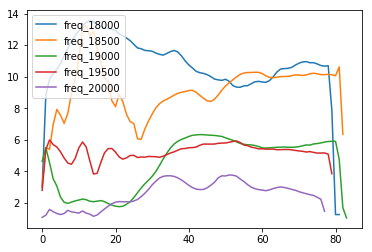

In [14]:
for i in range(18 * 1000, 20 * 1000 + 1, 500):
    plt.plot(cs_result['freq_{}'.format(i)], label = 'freq_{}'.format(i))
plt.legend()